# Week 2: Predicting time series

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create one step forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import unittests

## Generating the data

First things first, you will need to generate your time series data. 

The next cell includes a bunch of helper functions to generate and plot the time series. These are very similar to those you saw on Week 1.

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Now, define a function to generate the time series, using the functions from the previous cell. This function should return a time series that has trend, seasonality and noise. 

In [4]:
def generate_time_series():
    """ Creates timestamps and values of the time series """
    
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

## Defining some useful global variables

Next, you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length of the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.**


In [5]:
# Save all global variables
SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

Finally, put everything together and create the times series you will use for this assignment. 

In [6]:
# Create the time series
TIME, SERIES = generate_time_series()

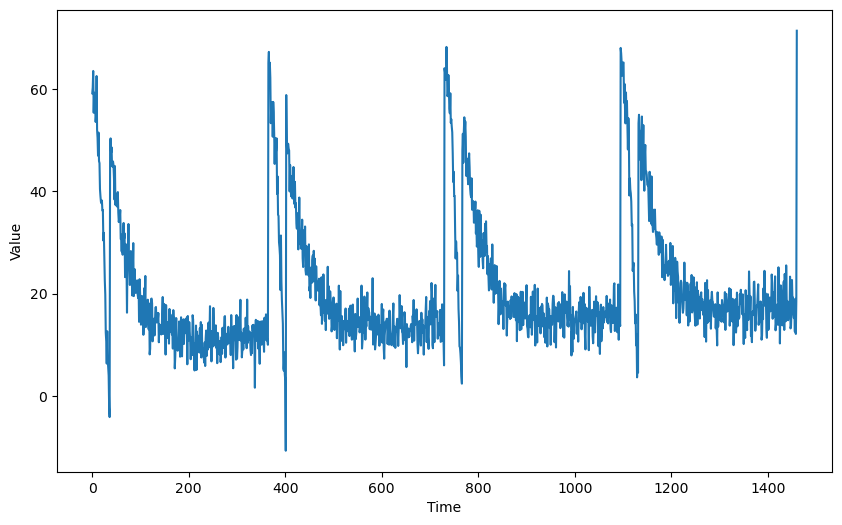

In [7]:
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

## Splitting the data

As usual, you will need a function to split the data between train and validation sets. Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [8]:
def train_val_split(time, series):

    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

## Processing the data

### Exercise 1: windowed_dataset

As you saw on the lectures, you can feed the data for training by creating a TF Dataset with the appropriate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. Remember you can do all these using the different methods of the `tf.data.Dataset` object. Next, complete the `windowed_dataset` function below that effectively pre-processes your time series and returns a TF Dataset.

This function receives a `series` and a `window_size`, and returns a TF Dataset. You should already be familiar with `tf.data.Dataset` objects from the this week's lectures, but be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) if you need any help.

In [76]:
# GRADED FUNCTION: windowed_dataset
def windowed_dataset(series, window_size, shuffle=True):
    """Create a windowed dataset

    Args:
        series (np.ndarray): time series
        window_size (int): length of window to use for prediction
        shuffle (bool): (For testing purposes) Indicates whether to shuffle data before batching or not. Defaults to True

    Returns:
        td.data.Dataset: windowed dataset
    """
    
    ### START CODE HERE ###
    # Create dataset from the series. 
    # HINT: use an appropriate method from the tf.data.Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    
    # Shuffle it
    if shuffle:  # For testing purposes
        dataset = dataset.shuffle(buffer_size=10) 
    
    # Split it into the features and labels. 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batch it
    dataset = dataset.batch(32)
    
    ### END CODE HERE ###
    
    return dataset

To test your function you will be using a `window_size` of 10 which means that you will use 10 consecutive values to predict the next one. You will also set the parameter `shuffle=False`. Given this, the first element of the batch of features should be identical to the first 15 elements of the `series_train`, and the batch of labels should be equal to elements 10 through 42 of the `series_train`.

In [77]:
# Try out your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=10,shuffle= False)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"First element in batch_of_features is equal to first 10 elements in the series: {np.allclose(batch_of_features.numpy()[0].flatten(), series_train[:10])}\n")
print(f"batch_of_labels is equal to the first 32 values after the window_lenght of 10): {np.allclose(batch_of_labels.numpy(), series_train[10:BATCH_SIZE+10])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (32, 10)

batch_of_labels has shape: (32,)

First element in batch_of_features is equal to first 10 elements in the series: True

batch_of_labels is equal to the first 32 values after the window_lenght of 10): True


**Expected Output:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (32, 10)

batch_of_labels has shape: (32,)

First element in batch_of_features is equal to first 10 elements in the series: True

batch_of_labels is equal to the first 32 values after the window_lenght of 10): True
```

Now plot the first item in the batch. You will be displayng the 20 features, followed by the label, which is the value you want to predict. 

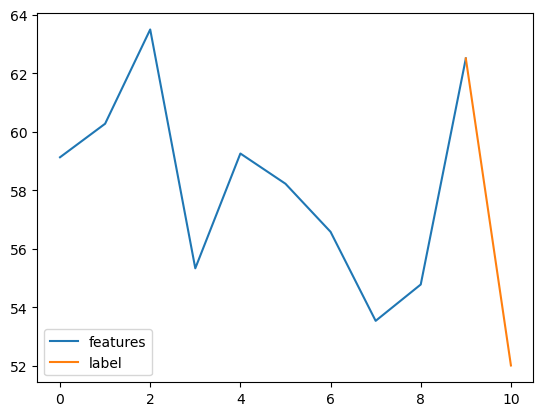

In [78]:
plt.plot(np.arange(10), batch_of_features[0].numpy(), label='features')
plt.plot(np.arange(9,11), [batch_of_features[0].numpy()[-1], batch_of_labels[0].numpy()], label='label');
plt.legend()

Now that you have tested your `windowed_dataset` function, use it to create your train dataset. For that, just run the cell below

In [79]:
# Apply the processing to the whole training series
train_dataset = windowed_dataset(series_train, WINDOW_SIZE)

In [80]:
# Test your code!
unittests.test_windowed_dataset(windowed_dataset)

 All tests passed!


## Defining the model architecture

### Exercise 2: create_model 

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you model architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Remember that this time you are predicting the values of a time series, so use an appropriate loss for this task. There are many you can choose for, but for grading purposes, please stick to 'mse'. 

Hint:
- You will only need `Dense` layers.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.



In [81]:
# GRADED FUNCTION: create_model
def create_model(window_size):
    """Create model for predictions
    Args:
        window_size (int): length of window to use for prediction

    Returns:
        tf.keras.Model: model
    """
    ### START CODE HERE ###

    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Input(shape=(window_size,)),
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(1)        
    ]) 

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
    
    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [82]:
# Get the untrained model
model = create_model(WINDOW_SIZE)

# Check the parameter count against a reference solution
unittests.parameter_count(model)

Your model has 331 total parameters and the reference is 3,200. You are good to go!

Your model has 331 trainable parameters and the reference is 3,200. You are good to go!


In [83]:
example_batch = train_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 1)


**Expected output:**
```
predictions have shape: (NUM_BATCHES, 1)

Where NUM_BATCHES is the number of batches you have set to your dataset.
```

Before going any further, check that the input and output dimensions of your model are correct. Do this by running the cell below:

In [84]:
print(f'Model input shape: {model.input_shape}')
print(f'Model output shape: {model.output_shape}')

Model input shape: (None, 20)
Model output shape: (None, 1)


You can also print a summary of your model to see what the architecture looks like. 

In [85]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Test your code!
unittests.test_create_model(create_model, windowed_dataset)

 All tests passed!


In [87]:
# Train it
history = model.fit(train_dataset, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 447.7296
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.7682
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.1470
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.0764
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.6692
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.4760
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.2866
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.0584
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.2137
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.0668
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.9980
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.4508
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.0242
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.5092
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

Now go ahead and plot the training loss so you can monitor the learning process.

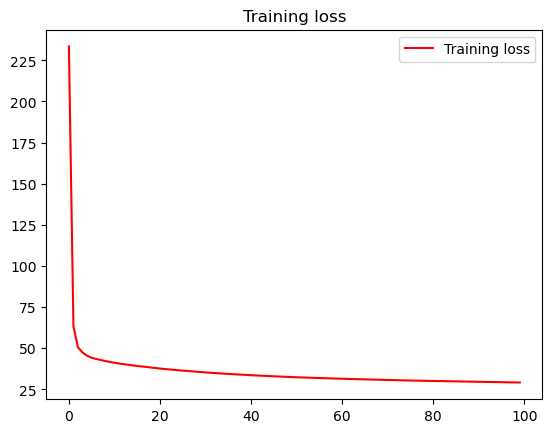

In [88]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [89]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

You will also be generating `predict_forecast` function, that simply computes predictions for all values in the validation data. 

In [90]:
def generate_forecast(model, series, window_size):
    forecast = []
    for time in range(SPLIT_TIME, len(series)):
        pred = model.predict(series[time-window_size:time][np.newaxis], verbose=0)
        forecast.append(pred[0][0])
    return forecast

Now, go ahead and make the predictions. This run should take no more time than the actual training.  

In [91]:
# Save the forecast
dnn_forecast = generate_forecast(model, SERIES, WINDOW_SIZE)

You can now plot the true series, and the predicted series in order to get a visual estimate of how good your model is doing.

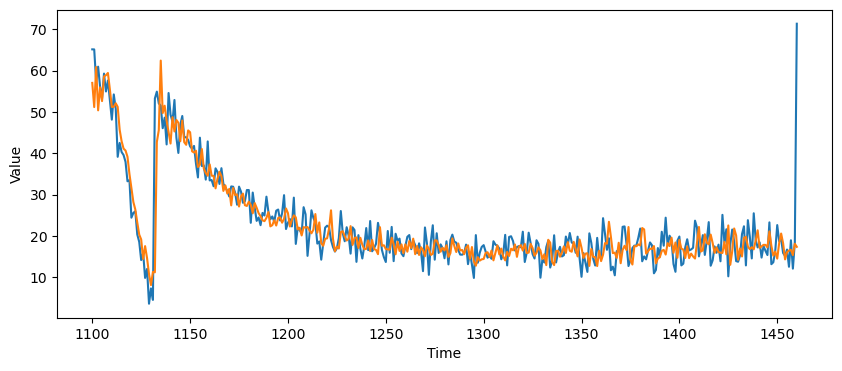

In [92]:
# Plot it
plt.figure(figsize=(10, 4))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/forecast.png" width="800">
</div>

Finally, go ahead and compute the MSE and MAE metrics using the `compute_metrics` function you defined earlier.

In [93]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 28.83, mae: 3.33 for forecast


**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the MSE in a binary file which will be used for grading and after doing so, submit your assigment for grading.

In [94]:
# ONLY RUN THIS CELL IF YOUR MSE ACHIEVED THE DESIRED MSE LEVEL
# Save your model 
model.save('trained_model.keras')

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series while also learning how to leverage Tensorflow's Dataset class to process time series data!

**Keep it up!**